In [1]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy

In [2]:
age_class = ["<1", "1-4", "5-9", "10-14", "15-19", "20-29", "30+"]

In [3]:
#Select disease
d = "Measles"

#monthly data
data = pd.read_csv( d +'_data_processed.csv')
monthly_data = data.iloc[:,1:8]
monthly_data = monthly_data[age_class]

#I do not consider 2019
monthly_data = monthly_data.iloc[0:(data.shape[0]-12),:]

time_date = data["Time"][0:(data.shape[0]-12)]

In [4]:
print(time_date[0])
print(time_date[len(time_date)-1])

years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1


print(years_run, "--> tmax")


1999-01
2018-12
20 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [5]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
Births_years = Births.iloc[0:(2018-1999+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = np.asarray(list(reversed(Births_UK)))

print(Births_UK)

[11.9 11.5 11.3 11.3 11.7 11.9 12.  12.3 12.6 12.8 12.7 12.9 12.8 12.8
 12.1 12.  11.9 11.8 11.4 11. ]


In [6]:
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018
Deaths_years = Deaths.iloc[:,np.where(Deaths.columns=="1999")[0][0]:np.where(Deaths.columns=="2018")[0][0]+1]

print(Deaths_years)
#Deaths_years.iloc[:,0].to_numpy()

       1999      2000      2001      2002      2003      2004      2005  \
0  0.005762  0.005588  0.005570  0.005346  0.005421  0.005194  0.005126   
1  0.000278  0.000236  0.000233  0.000239  0.000244  0.000231  0.000218   
2  0.000118  0.000117  0.000120  0.000109  0.000111  0.000100  0.000096   
3  0.000151  0.000135  0.000146  0.000142  0.000140  0.000124  0.000137   
4  0.000434  0.000423  0.000422  0.000408  0.000380  0.000376  0.000377   
5  0.000651  0.000653  0.000621  0.000624  0.000603  0.000572  0.000533   
6  0.017067  0.016406  0.016096  0.016069  0.016072  0.015269  0.015122   

       2006      2007      2008      2009      2010      2011      2012  \
0  0.005091  0.004938  0.004751  0.004698  0.004425  0.004371  0.004102   
1  0.000228  0.000227  0.000210  0.000182  0.000182  0.000181  0.000164   
2  0.000102  0.000096  0.000107  0.000093  0.000094  0.000083  0.000089   
3  0.000131  0.000127  0.000101  0.000108  0.000099  0.000089  0.000095   
4  0.000366  0.000351  0

In [7]:
#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns=="1999")[0][0]:np.where(Deaths.columns=="2018")[0][0]+1]

#print(Pops_tot)

Pops_tot = np.asarray(Pops_tot)

##### Including real contact matrix from Polymod

- equally weighted one

In [8]:
Poly_7_new = pd.read_csv("Data/Poly_7.csv")
Poly_7_new = Poly_7_new.iloc[:,1:8]
C_poly = Poly_7_new.values

In [9]:
Poly_7_new

,<1,1-4,5-9,10-14,15-19,20-29,30+
0,1.49,1.49,0.59,0.25,0.18,0.515,0.301111
1,0.74,0.74,3.82,0.53,0.44,0.395,0.402222
2,0.36,0.36,0.73,3.19,0.79,0.155,0.308889
3,0.26,0.26,0.22,0.52,3.10,0.485,0.285556
4,0.92,0.92,0.56,0.20,0.58,1.515,0.417778
5,2.94,2.94,2.84,2.21,1.86,1.975,2.127778
6,1.49,1.49,0.59,0.25,0.18,0.515,0.301111


#### Vaccine coverage and Vaccinated IC

In [10]:
Vacc_rate = pd.read_csv("Data//" +d +'_vaccine_coverage.csv')
V_ic = Vacc_rate.iloc[0:7,1:2]
V_ic = V_ic.to_numpy().reshape((7,))
Vacc_rate_years = Vacc_rate.iloc[0:7,2:21]

# Issue: vaccination rate is up until 2016, now assume 2017-19 are the same?
Vacc_rate_years["2017"] = Vacc_rate_years["2018"]  = Vacc_rate_years["2016"]


In [11]:
para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B= lambda t: (Births_UK/1000)[int(np.floor(t))],  #births rate per capita
    V=lambda t: Vacc_rate_years.to_numpy()[:, int(np.floor(t))],
    d=lambda t: Deaths_years.to_numpy()[:, int(np.floor(t))],  #death rate
    gamma=(1.0/14.0*365.0)*np.ones([7]),
    C=C_poly,
    N= lambda t: Pops_tot[int(np.floor(t))]
)

In [12]:
beta = np.eye(7)*[0.98, 0.9, 0.85, 0.8, 0.7, 0.7, 0.7]*365.0 #This scales with time (to check compute r0)!

In [13]:
mdl = m.SIRVModel(para, lambda t: beta)

In [14]:
np.ones(7) - V_ic/100

array([1.        , 0.109625  , 0.03100689, 0.00803827, 0.36      ,
       0.497     , 1.        ])

In [15]:
S_ic = np.hstack([(0.95*((np.ones(7)-V_ic/100)[0:2])), (0.15*((np.ones(7)-V_ic/100)[2:7]))])
I_ic = np.hstack([(0.05*((np.ones(7)-V_ic/100)[0])), (0.025*((np.ones(7)-V_ic/100)[1:7]))])
V_ic = V_ic/100 
R_ic = np.ones(7) - S_ic - I_ic - V_ic

In [16]:
new_ic = np.hstack([S_ic, I_ic, R_ic, V_ic])

In [17]:
#Sanity check
np.sum(new_ic, axis = 0)

6.999999999999999

In [26]:
#out_year, t_year = mdl.run(np.hstack([0.95*(1./7)*np.ones(7), 0.05*(1./7)*np.ones(7), np.zeros(7*2)]),t_max = 19,method="RK45", eval_per_year=24)

out_year, t_year = mdl.run(new_ic ,t_max = 19, method="LSODA", eval_per_year=52)#Use more iterations!, LSODA maybe better 

In [27]:
out = out_year
t = t_year

In [28]:
out.shape

(28, 988)

Text(0.5, 1.0, 'Infected curve for all age groups (unnormalized)')

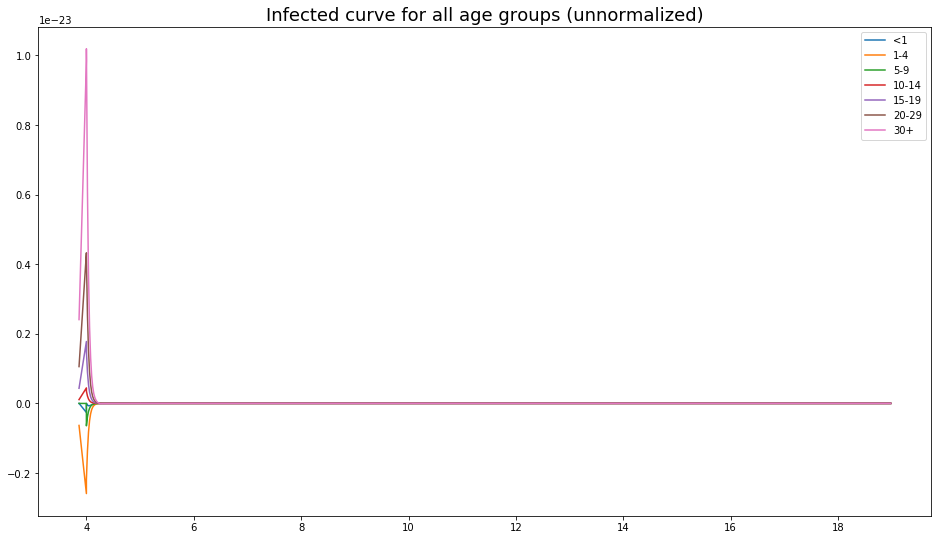

In [31]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t[200:len(t)-1], np.transpose(out[7+ii,200:len(t)-1]), label = age_class[ii])
plt.legend()
plt.title("Infected curve for all age groups (unnormalized)", fontsize = 18)

Text(0.5, 1.0, 'Vaccinated curve for all age groups (unnormalized)')

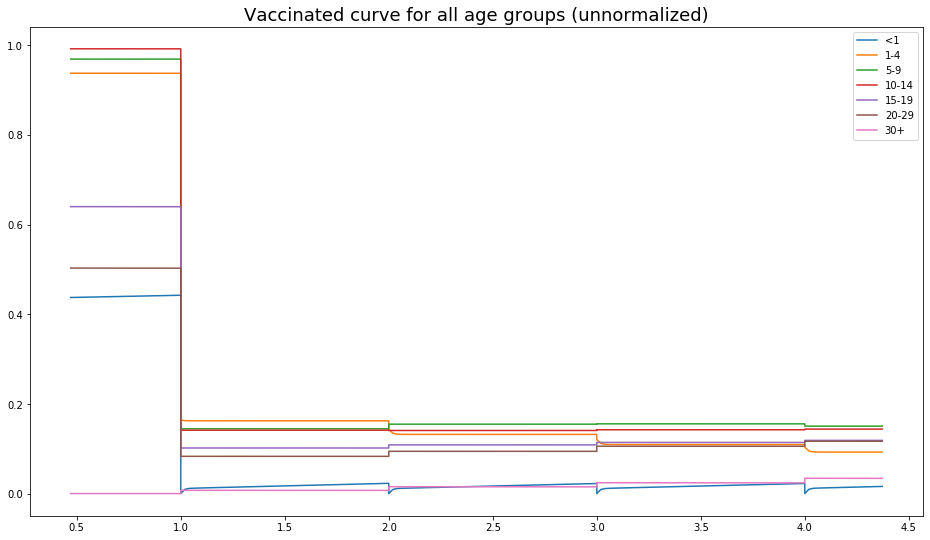

In [32]:
out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t[24:228], np.transpose(out[21+ii,24:228]), label = age_class[ii])
plt.legend()

plt.title("Vaccinated curve for all age groups (unnormalized)", fontsize = 18)

#### Plotting the scaled infected by normalising pop

In [23]:
Inf_OUT.shape
Pops_struct = Pops.iloc[0:7,np.where(Deaths.columns=="1999")[0][0]:np.where(Deaths.columns=="2018")[0][0]+1]

In [24]:
for yy in range(Pops_tot[1:20].shape[0]):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-24-eb34ece9e21f>, line 2)

In [ ]:
np.sum(out, axis = 1)

In [ ]:
Inf_OUT

In [ ]:
monthly_data_cut = monthly_data.iloc[0:(monthly_data.shape[0]-12),:]

In [ ]:
def f_ssq(beta_vec):
    beta = np.eye(7)*beta_vec
    mdl = m.SIRVModel(para, lambda t: beta)
    out, t = mdl.run(new_ic ,t_max = 19,method="RK45", eval_per_year=12)
    
    #Something to do with this monthly cases
    
    groups = int(out.shape[0]/4)
    ssq_diff = 0
    for ii in range(groups):
        Inf_group = out[7+ii,:]
        #monthly data
        #adding the squared diff
        ssq_diff += np.sum((Inf_group - monthly_data_cut[age_class[ii]].to_numpy())**2)
    return ssq_diff

In [ ]:
fit_measles = scipy.optimize.fmin(f_ssq, x0 = np.array([0.98, 0.9, 0.85, 0.8, 0.7, 0.7, 0.7]), xtol=0.0001
                                  ,maxiter = 100, maxfun = 10,full_output=1)

In [ ]:
fit_measles[0]

In [ ]:
fit_measles = scipy.optimize.fmin(f_ssq, x0 = np.array([0.98, 0.9, 0.85, 0.8, 0.7, 0.7, 0.7]), xtol=0.0001
                                  ,maxiter = 1000, maxfun = 10,full_output=1)

In [ ]:
fit_measles[0]

In [ ]:
fit_measles = scipy.optimize.fmin(f_ssq, x0 = np.array([0.9, 0.9, 0.8, 0.8, 0.7, 0.7, 0.6]), xtol=0.0001
                                  ,maxiter = 1000, maxfun = 20,full_output=1)

In [ ]:
fit_measles[0]